### Creation d'un echantillong d'entrainement 

In [1]:
import pandas as pd
import numpy as np

def create_most_active_users_dataset():
    # 1. Lecture du fichier
    print("Lecture du fichier original...")
    df = pd.read_csv('prediction_log/dfspark_train_log_final.csv')
    
    # 2. Calculer le nombre de sessions par utilisateur
    print("Calcul du nombre de sessions par utilisateur...")
    sessions_per_user = df.groupby('username')['session_id'].nunique().reset_index()
    sessions_per_user = sessions_per_user.sort_values('session_id', ascending=False)
    
    # 3. Sélectionner les 10% supérieurs
    n_users = len(sessions_per_user)
    n_top_users = int(np.ceil(n_users * 0.00003))
    top_users = sessions_per_user.head(n_top_users)['username'].tolist()
    
    # 4. Créer le nouveau dataset avec ces utilisateurs
    df_active = df[df['username'].isin(top_users)].copy()
    
    # 5. Sauvegarder dans un nouveau fichier
    output_file = 'prediction_log/top_01percent_most_sessions.csv'
    df_active.to_csv(output_file, index=False)
    
    # 6. Afficher les statistiques
    print("\nStatistiques du dataset:")
    print(f"Nombre total d'utilisateurs original: {n_users}")
    print(f"Nombre d'utilisateurs sélectionnés: {len(top_users)}")
    print(f"Nombre de lignes dans le nouveau dataset: {len(df_active)}")
    
    print("\nTop 5 utilisateurs par nombre de sessions:")
    top_5_stats = sessions_per_user.head().merge(
        df_active.groupby('username').agg({
            'action': 'count',
            'session_duration': 'sum'
        }).reset_index(),
        on='username'
    )
    print(top_5_stats.rename(columns={
        'session_id': 'nombre_sessions',
        'action': 'nombre_actions',
        'session_duration': 'duree_totale'
    }))
    
    return df_active

if __name__ == "__main__":
    df_active = create_most_active_users_dataset()

Lecture du fichier original...


C:\Users\ayoub\AppData\Local\Temp\ipykernel_2384\220733151.py:7: DtypeWarning: Columns (0,1,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('prediction_log/dfspark_train_log_final.csv')


Calcul du nombre de sessions par utilisateur...

Statistiques du dataset:
Nombre total d'utilisateurs original: 71499
Nombre d'utilisateurs sélectionnés: 3
Nombre de lignes dans le nouveau dataset: 17254

Top 5 utilisateurs par nombre de sessions:
  username  nombre_sessions  nombre_actions  \
0     1921              219            6918   
1   324959              204            6291   
2     1921              169            4045   

                                        duree_totale  
0  2929222141476767676767626667266672666726667266...  
1                                          213092762  
2                                          230638719  


### Graph construction

In [2]:
import pandas as pd
import numpy as np
import torch
import torch_geometric
from torch_geometric.data import Data
from collections import defaultdict

def create_session_graphs(csv_path):
    # Read the CSV file
    df = pd.read_csv(csv_path)
    
    # Convert timestamp to datetime
    df['time'] = pd.to_datetime(df['time'])
    
    # Group by user and session
    user_session_graphs = {}
    
    for (username, session_id), session_data in df.groupby(['username', 'session_id']):
        # Sort session data by timestamp
        session_data_sorted = session_data.sort_values('time')
        
        # Create graph for this session
        graph = create_single_session_graph(session_data_sorted)
        
        # Organize graphs by user
        if username not in user_session_graphs:
            user_session_graphs[username] = []
        user_session_graphs[username].append(graph)
    
    return user_session_graphs

def create_single_session_graph(session_data):
    # Unique actions in this session
    unique_actions = session_data['action'].unique()
    action_to_index = {action: idx for idx, action in enumerate(unique_actions)}
    
    # Node features
    node_features = []
    node_labels = []
    
    # Compute node features
    action_counts = session_data['action'].value_counts()
    session_duration = session_data['session_duration'].iloc[0]  # Session duration
    
    for action in unique_actions:
        # Node features: [action_count_in_session, session_duration]
        node_features.append([
            action_counts.get(action, 0),
            session_duration
        ])
        node_labels.append(action)
    
    # Convert to tensor
    node_features = torch.tensor(node_features, dtype=torch.float)
    
    # Create edges between actions
    edges = defaultdict(int)
    edge_features = defaultdict(list)
    
    # Create edges between consecutive actions
    actions = session_data['action'].tolist()
    times = session_data['time'].tolist()
    
    for i in range(len(actions) - 1):
        source = action_to_index[actions[i]]
        target = action_to_index[actions[i+1]]
        
        # Time between actions
        time_diff = (times[i+1] - times[i]).total_seconds()
        
        edges[(source, target)] += 1
        edge_features[(source, target)].append(time_diff)
    
    # Convert edges to tensor
    edge_index = []
    edge_attr = []
    
    for (source, target), count in edges.items():
        edge_index.append([source, target])
        
        # Edge features: 
        # 1. Frequency of action transition
        # 2. Average time between actions
        avg_time = np.mean(edge_features[(source, target)])
        edge_attr.append([count, avg_time])
    
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    
    # Create PyG Data object
    graph = Data(
        x=node_features,
        edge_index=edge_index,
        edge_attr=edge_attr,
        node_labels=node_labels,
        session_duration=session_duration
    )
    
    return graph

# Globally scope the user_session_graphs variable
user_session_graphs = None

def main():
    global user_session_graphs
    # Path to your CSV file
    csv_path = 'prediction_log/top_01percent_most_sessions.csv'
    
    # Generate session graphs
    user_session_graphs = create_session_graphs(csv_path)
    
    # Print some information about the graphs
    for username, session_graphs in list(user_session_graphs.items())[:5]:
        print(f"\nUser {username}:")
        print(f"Number of sessions: {len(session_graphs)}")
        
        for i, graph in enumerate(session_graphs):
            print(f"\nSession {i+1}:")
            print(f"Nodes: {graph.x}")
            print(f"Node Labels: {graph.node_labels}")
            print(f"Edges: {graph.edge_index}")
            print(f"Edge Attributes: {graph.edge_attr}")
            print(f"Session Duration: {graph.session_duration}")
    
    return user_session_graphs

if __name__ == "__main__":
    user_session_graphs = main()


User 1921:
Number of sessions: 303

Session 1:
Nodes: tensor([[ 10., 626.],
        [  5., 626.],
        [ 20., 626.],
        [  2., 626.]])
Node Labels: ['click_courseware', 'close_courseware', 'problem_get', 'click_info']
Edges: tensor([[0, 0, 1, 1, 2, 2, 0, 2, 0, 3, 3],
        [0, 1, 0, 2, 2, 0, 2, 1, 3, 3, 0]])
Edge Attributes: tensor([[3.0000e+00, 2.3333e+00],
        [3.0000e+00, 1.0000e+00],
        [3.0000e+00, 3.3333e-01],
        [2.0000e+00, 5.0000e-01],
        [1.6000e+01, 2.5000e-01],
        [2.0000e+00, 1.0000e+00],
        [2.0000e+00, 4.0000e+00],
        [2.0000e+00, 2.8700e+02],
        [1.0000e+00, 1.0000e+00],
        [1.0000e+00, 2.3000e+01],
        [1.0000e+00, 2.0000e+00]])
Session Duration: 626

Session 2:
Nodes: tensor([[2., 5.],
        [2., 5.]])
Node Labels: ['click_about', 'click_info']
Edges: tensor([[0, 0, 1],
        [0, 1, 1]])
Edge Attributes: tensor([[1., 2.],
        [1., 1.],
        [1., 2.]])
Session Duration: 5

Session 3:
Nodes: tensor([[

In [3]:
user_session_graphs

{np.int64(1921): [Data(x=[4, 2], edge_index=[2, 11], edge_attr=[11, 2], node_labels=[4], session_duration=626),
  Data(x=[2, 2], edge_index=[2, 3], edge_attr=[3, 2], node_labels=[2], session_duration=5),
  Data(x=[2, 2], edge_index=[2, 2], edge_attr=[2, 2], node_labels=[2], session_duration=25),
  Data(x=[2, 2], edge_index=[2, 1], edge_attr=[1, 2], node_labels=[2], session_duration=2),
  Data(x=[1, 2], edge_index=[0], edge_attr=[0], node_labels=[1], session_duration=0),
  Data(x=[2, 2], edge_index=[2, 1], edge_attr=[1, 2], node_labels=[2], session_duration=6),
  Data(x=[2, 2], edge_index=[2, 1], edge_attr=[1, 2], node_labels=[2], session_duration=0),
  Data(x=[12, 2], edge_index=[2, 28], edge_attr=[28, 2], node_labels=[12], session_duration=2190),
  Data(x=[3, 2], edge_index=[2, 7], edge_attr=[7, 2], node_labels=[3], session_duration=246657),
  Data(x=[4, 2], edge_index=[2, 10], edge_attr=[10, 2], node_labels=[4], session_duration=7148),
  Data(x=[7, 2], edge_index=[2, 17], edge_attr=[

## Data preparation for Training (train_test Split)

In [ ]:
import random
import torch
from sklearn.model_selection import train_test_split

def create_training_pairs(user_session_graphs, test_size=0.2):
    train_pairs = []
    test_pairs = []
    
    for username, sessions in user_session_graphs.items():
        if len(sessions) < 2:  # Skip users with too few sessions
            continue
            
        train_sessions, test_sessions = train_test_split(sessions, test_size=test_size, random_state=42)
        
        # Train positives
        for i in range(len(train_sessions)):
            for j in range(i+1, len(train_sessions)):
                train_pairs.append({
                    'graph1': train_sessions[i],
                    'graph2': train_sessions[j],
                    'label': 1,
                    'user': username
                })
        
        # Train negatives
        other_users = list(user_session_graphs.keys())
        other_users.remove(username)
        
        for _ in range(len(train_pairs)):  # Match number of positives
            other_user = random.choice(other_users)
            other_session = random.choice(user_session_graphs[other_user])
            train_session = random.choice(train_sessions)
            
            train_pairs.append({
                'graph1': train_session,
                'graph2': other_session,
                'label': 0,
                'user': username
            })
            
        # Test pairs
        for test_session in test_sessions:
            # Test positives
            for train_session in train_sessions:
                test_pairs.append({
                    'graph1': test_session,
                    'graph2': train_session,
                    'label': 1,
                    'user': username
                })
            
            # Test negatives
            for _ in range(len(train_sessions)):
                other_user = random.choice(other_users)
                other_session = random.choice(user_session_graphs[other_user])
                test_pairs.append({
                    'graph1': test_session,
                    'graph2': other_session,
                    'label': 0,
                    'user': username
                })
    
    return train_pairs, test_pairs


In [14]:
train_pairs

[{'graph1': Data(x=[5, 2], edge_index=[2, 9], edge_attr=[9, 2], node_labels=[5], session_duration=233),
  'graph2': Data(x=[10, 2], edge_index=[2, 46], edge_attr=[46, 2], node_labels=[10], session_duration=203),
  'label': 1,
  'user': np.int64(1921)},
 {'graph1': Data(x=[5, 2], edge_index=[2, 9], edge_attr=[9, 2], node_labels=[5], session_duration=233),
  'graph2': Data(x=[5, 2], edge_index=[2, 11], edge_attr=[11, 2], node_labels=[5], session_duration=2093),
  'label': 1,
  'user': np.int64(1921)},
 {'graph1': Data(x=[5, 2], edge_index=[2, 9], edge_attr=[9, 2], node_labels=[5], session_duration=233),
  'graph2': Data(x=[10, 2], edge_index=[2, 48], edge_attr=[48, 2], node_labels=[10], session_duration=21004),
  'label': 1,
  'user': np.int64(1921)},
 {'graph1': Data(x=[5, 2], edge_index=[2, 9], edge_attr=[9, 2], node_labels=[5], session_duration=233),
  'graph2': Data(x=[1, 2], edge_index=[2, 1], edge_attr=[1, 2], node_labels=[1], session_duration=9118),
  'label': 1,
  'user': np.int6

In [27]:
# Vérifions la structure des paires
print("Exemple d'une paire d'entraînement:")
print(train_pairs[0])

# Vérifions les dimensions des graphes
print("\nDimensions des graphes:")
print(f"Nodes features: {train_pairs[0]['graph1'].x.shape}")
print(f"Edge index: {train_pairs[0]['graph1'].edge_index.shape}")
print(f"Edge attr: {train_pairs[0]['graph1'].edge_attr.shape}")

# Vérifions si les tenseurs sont sur CPU/GPU
print("\nDevice des tenseurs:")
print(f"Nodes: {train_pairs[0]['graph1'].x.device}")
print(f"Edges: {train_pairs[0]['graph1'].edge_index.device}")

# Vérifions les types de données
print("\nTypes de données:")
print(f"Nodes: {train_pairs[0]['graph1'].x.dtype}")
print(f"Edges: {train_pairs[0]['graph1'].edge_index.dtype}")
print(f"Label: {type(train_pairs[0]['label'])}")

Exemple d'une paire d'entraînement:
{'graph1': Data(x=[5, 2], edge_index=[2, 9], edge_attr=[9, 2], node_labels=[5], session_duration=233), 'graph2': Data(x=[10, 2], edge_index=[2, 46], edge_attr=[46, 2], node_labels=[10], session_duration=203), 'label': 1, 'user': np.int64(1921)}

Dimensions des graphes:
Nodes features: torch.Size([5, 2])
Edge index: torch.Size([2, 9])
Edge attr: torch.Size([9, 2])

Device des tenseurs:
Nodes: cuda:0
Edges: cuda:0

Types de données:
Nodes: torch.float32
Edges: torch.int64
Label: <class 'int'>


In [35]:
def inspect_dataset(user_session_graphs, train_pairs, test_pairs):
    print("DATASET OVERVIEW")
    print(f"Users: {len(user_session_graphs)}")
    
    # Sessions stats
    sessions_per_user = [len(sessions) for sessions in user_session_graphs.values()]
    print(f"Sessions per user: Min={min(sessions_per_user)}, Max={max(sessions_per_user)}, Avg={sum(sessions_per_user)/len(sessions_per_user):.1f}")
    
    # Inspecting graph structures
    print("\nGRAPH STRUCTURES:")
    for username, sessions in list(user_session_graphs.items())[:3]:
        print(f"\nUser {username} - {len(sessions)} sessions")
        for i, g in enumerate(sessions[:2]):
            print(f"\nSession {i}:")
            print(f"Nodes: {g.x.shape}")
            print(f"Edges: {g.edge_index.shape}")
            if hasattr(g, 'edge_attr') and g.edge_attr is not None:
                print(f"Edge attributes: {g.edge_attr.shape}")
            else:
                print("No edge attributes")

inspect_dataset(user_session_graphs, train_pairs, test_pairs)

DATASET OVERVIEW
Users: 2
Sessions per user: Min=204, Max=303, Avg=253.5

GRAPH STRUCTURES:

User 1921 - 303 sessions

Session 0:
Nodes: torch.Size([4, 2])
Edges: torch.Size([2, 11])
Edge attributes: torch.Size([11, 2])

Session 1:
Nodes: torch.Size([2, 2])
Edges: torch.Size([2, 3])
Edge attributes: torch.Size([3, 2])

User 324959 - 204 sessions

Session 0:
Nodes: torch.Size([3, 2])
Edges: torch.Size([2, 4])
Edge attributes: torch.Size([4, 2])

Session 1:
Nodes: torch.Size([1, 2])
Edges: torch.Size([0])
Edge attributes: torch.Size([0])


In [36]:
def inspect_edge_attributes(user_session_graphs):
   edge_attr_stats = {
       'min_attrs': float('inf'),
       'max_attrs': 0,
       'empty_edges': 0,
       'total_graphs': 0
   }
   
   for username, sessions in user_session_graphs.items():
       for g in sessions:
           edge_attr_stats['total_graphs'] += 1
           
           if not hasattr(g, 'edge_attr') or g.edge_attr is None or g.edge_attr.shape[0] == 0:
               edge_attr_stats['empty_edges'] += 1
               continue
               
           edge_attr_stats['min_attrs'] = min(edge_attr_stats['min_attrs'], g.edge_attr.shape[0])
           edge_attr_stats['max_attrs'] = max(edge_attr_stats['max_attrs'], g.edge_attr.shape[0])

   print(f"Total graphs: {edge_attr_stats['total_graphs']}")
   print(f"Graphs with empty edges: {edge_attr_stats['empty_edges']}")
   print(f"Edge attributes range: {edge_attr_stats['min_attrs']} to {edge_attr_stats['max_attrs']}")
   
inspect_edge_attributes(user_session_graphs)

Total graphs: 507
Graphs with empty edges: 20
Edge attributes range: 1 to 60


### Model Training

In [56]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.metrics import precision_recall_fscore_support
from tqdm import tqdm

class GraphEmbedder(nn.Module):
   def __init__(self, node_dim=2, embedding_dim=8):
       super().__init__()
       self.conv = GCNConv(node_dim, embedding_dim)
       
   def forward(self, x, edge_index):
       x = x.float()
       if edge_index.nelement() == 0:
           return torch.zeros(1, self.conv.out_channels, device=x.device)
       x = self.conv(x, edge_index)
       return global_mean_pool(x, torch.zeros(x.size(0), device=x.device, dtype=torch.long))

def train_model(embeddings, labels, epochs=10, batch_size=64):
   classifier = Classifier().to(device)
   optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
   criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([2.0]).to(device))
   
   embeddings = F.normalize(embeddings, p=2, dim=1)
   
   for epoch in tqdm(range(epochs)):
       classifier.train()
       perm = torch.randperm(len(embeddings))
       epoch_loss = 0
       
       for i in range(0, len(embeddings), batch_size):
           idx = perm[i:i+batch_size]
           batch_emb = embeddings[idx]
           batch_labels = labels[idx].unsqueeze(-1).to(device)  # Ajout unsqueeze
           
           pred = classifier(batch_emb)
           loss = criterion(pred, batch_labels)
           
           optimizer.zero_grad()
           loss.backward()
           torch.nn.utils.clip_grad_norm_(classifier.parameters(), 1.0)
           optimizer.step()
           
           epoch_loss += loss.item()
           
       with torch.no_grad():
           preds = torch.sigmoid(classifier(embeddings)) > 0.5
           metrics = precision_recall_fscore_support(
               labels.cpu(), 
               preds.cpu(), 
               average='binary',
               zero_division=1
           )
           print(f"Epoch {epoch+1} - Loss: {epoch_loss/(i//batch_size + 1):.4f}, F1: {metrics[2]:.4f}")
   
   return classifier
# Exécution
device = torch.device('cuda')
embedder = GraphEmbedder().to(device)

# Prétraitement
train_embeddings, train_labels, train_users = precompute_embeddings(train_pairs, embedder)
test_embeddings, test_labels, test_users = precompute_embeddings(test_pairs, embedder)

# Entraînement
classifier = train_model(train_embeddings, train_labels)

# Test final
with torch.no_grad():
   test_preds = (torch.sigmoid(classifier(test_embeddings)) > 0.5).squeeze().cpu()
   metrics = precision_recall_fscore_support(test_labels.cpu(), test_preds, average='binary')
   print(f"\nTest Results - P: {metrics[0]:.4f}, R: {metrics[1]:.4f}, F1: {metrics[2]:.4f}")

 10%|█         | 1/10 [00:04<00:37,  4.19s/it]

Epoch 1 - Loss: 0.8926, F1: 0.1174


 20%|██        | 2/10 [00:08<00:32,  4.03s/it]

Epoch 2 - Loss: 0.8905, F1: 0.1043


 30%|███       | 3/10 [00:12<00:27,  3.97s/it]

Epoch 3 - Loss: 0.8904, F1: 0.1285


 40%|████      | 4/10 [00:16<00:25,  4.30s/it]

Epoch 4 - Loss: 0.8900, F1: 0.1235


 50%|█████     | 5/10 [00:21<00:22,  4.56s/it]

Epoch 5 - Loss: 0.8901, F1: 0.1281


 60%|██████    | 6/10 [00:26<00:18,  4.71s/it]

Epoch 6 - Loss: 0.8902, F1: 0.1393


 70%|███████   | 7/10 [03:43<03:22, 67.50s/it]

Epoch 7 - Loss: 0.8901, F1: 0.1203


 80%|████████  | 8/10 [03:48<01:35, 47.50s/it]

Epoch 8 - Loss: 0.8901, F1: 0.1230


 90%|█████████ | 9/10 [03:52<00:34, 34.05s/it]

Epoch 9 - Loss: 0.8900, F1: 0.1031


100%|██████████| 10/10 [03:56<00:00, 23.67s/it]

Epoch 10 - Loss: 0.8899, F1: 0.1202

Test Results - P: 0.4994, R: 0.9032, F1: 0.6432


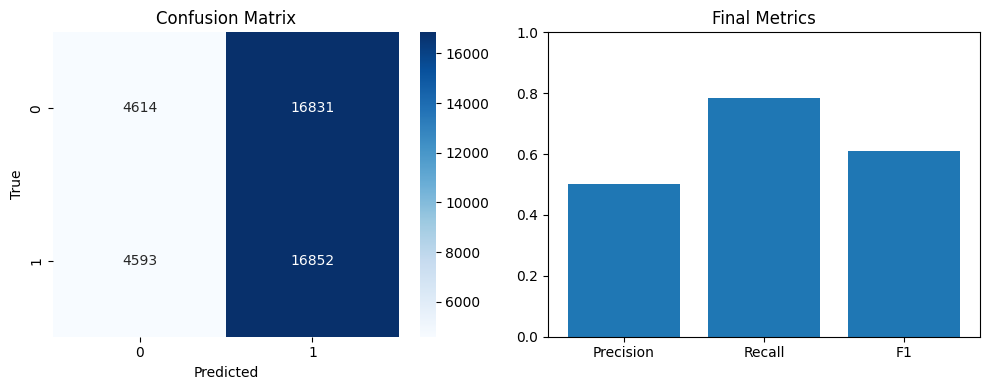

In [60]:
def plot_final_metrics(y_true, y_pred, save_plots=True):
   # Confusion Matrix
   plt.figure(figsize=(10, 4))
   
   plt.subplot(121)
   cm = confusion_matrix(y_true, y_pred)
   sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
   plt.title('Confusion Matrix')
   plt.ylabel('True')
   plt.xlabel('Predicted')
   
   # Metrics bars
   plt.subplot(122)
   metrics = precision_recall_fscore_support(y_true, y_pred, average='binary')
   metrics_dict = {'Precision': metrics[0], 'Recall': metrics[1], 'F1': metrics[2]}
   
   plt.bar(metrics_dict.keys(), metrics_dict.values())
   plt.ylim(0, 1)
   plt.title('Final Metrics')
   
   plt.tight_layout()
   if save_plots:
       plt.savefig('final_metrics.png')
   plt.show()

# Après test
with torch.no_grad():
   final_preds = (torch.sigmoid(classifier(test_embeddings)) > 0.5).cpu()
   plot_final_metrics(test_labels.cpu(), final_preds)

### model2_training

In [ ]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.metrics import precision_recall_fscore_support
from tqdm import tqdm

class GraphEmbedder(nn.Module):
   def __init__(self, node_dim=2, embedding_dim=8):
       super().__init__()
       self.conv = GCNConv(node_dim, embedding_dim)
       
   def forward(self, x, edge_index):
       x = x.float()
       if edge_index.nelement() == 0:
           return torch.zeros(1, self.conv.out_channels, device=x.device)
       x = self.conv(x, edge_index)
       return global_mean_pool(x, torch.zeros(x.size(0), device=x.device, dtype=torch.long))

def train_model(embeddings, labels, epochs=50, batch_size=64):
   classifier = Classifier().to(device)
   optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
   criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([2.0]).to(device))
   
   embeddings = F.normalize(embeddings, p=2, dim=1)
   
   for epoch in tqdm(range(epochs)):
       classifier.train()
       perm = torch.randperm(len(embeddings))
       epoch_loss = 0
       
       for i in range(0, len(embeddings), batch_size):
           idx = perm[i:i+batch_size]
           batch_emb = embeddings[idx]
           batch_labels = labels[idx].unsqueeze(-1).to(device)  # Ajout unsqueeze
           
           pred = classifier(batch_emb)
           loss = criterion(pred, batch_labels)
           
           optimizer.zero_grad()
           loss.backward()
           torch.nn.utils.clip_grad_norm_(classifier.parameters(), 1.0)
           optimizer.step()
           
           epoch_loss += loss.item()
           
       with torch.no_grad():
           preds = torch.sigmoid(classifier(embeddings)) > 0.5
           metrics = precision_recall_fscore_support(
               labels.cpu(), 
               preds.cpu(), 
               average='binary',
               zero_division=1
           )
           print(f"Epoch {epoch+1} - Loss: {epoch_loss/(i//batch_size + 1):.4f}, F1: {metrics[2]:.4f}")
   
   return classifier
# Exécution
device = torch.device('cuda')
embedder = GraphEmbedder().to(device)

# Prétraitement
train_embeddings, train_labels, train_users = precompute_embeddings(train_pairs, embedder)
test_embeddings, test_labels, test_users = precompute_embeddings(test_pairs, embedder)

# Entraînement
classifier = train_model(train_embeddings, train_labels)

# Test final
with torch.no_grad():
   test_preds = (torch.sigmoid(classifier(test_embeddings)) > 0.5).squeeze().cpu()
   metrics = precision_recall_fscore_support(test_labels.cpu(), test_preds, average='binary')
   print(f"\nTest Results - P: {metrics[0]:.4f}, R: {metrics[1]:.4f}, F1: {metrics[2]:.4f}")

  2%|▏         | 1/50 [00:04<03:40,  4.51s/it]

Epoch 1 - Loss: 0.8924, F1: 0.1876


  4%|▍         | 2/50 [00:09<03:39,  4.57s/it]

Epoch 2 - Loss: 0.8910, F1: 0.2042


  6%|▌         | 3/50 [00:13<03:33,  4.55s/it]

Epoch 3 - Loss: 0.8905, F1: 0.1890


  8%|▊         | 4/50 [00:18<03:26,  4.50s/it]

Epoch 4 - Loss: 0.8905, F1: 0.1864


 10%|█         | 5/50 [00:22<03:22,  4.51s/it]

Epoch 5 - Loss: 0.8907, F1: 0.1952


 12%|█▏        | 6/50 [00:27<03:17,  4.48s/it]

Epoch 6 - Loss: 0.8905, F1: 0.1863


 14%|█▍        | 7/50 [00:31<03:13,  4.50s/it]

Epoch 7 - Loss: 0.8904, F1: 0.1339


 16%|█▌        | 8/50 [00:36<03:17,  4.70s/it]

Epoch 8 - Loss: 0.8904, F1: 0.2096


 18%|█▊        | 9/50 [00:41<03:20,  4.88s/it]

Epoch 9 - Loss: 0.8904, F1: 0.1828


 20%|██        | 10/50 [00:47<03:26,  5.17s/it]

Epoch 10 - Loss: 0.8902, F1: 0.1663


 22%|██▏       | 11/50 [00:54<03:36,  5.55s/it]

Epoch 11 - Loss: 0.8905, F1: 0.1837


 24%|██▍       | 12/50 [01:00<03:45,  5.93s/it]

Epoch 12 - Loss: 0.8904, F1: 0.1966


 26%|██▌       | 13/50 [01:07<03:50,  6.23s/it]

Epoch 13 - Loss: 0.8903, F1: 0.1885


 28%|██▊       | 14/50 [01:14<03:47,  6.32s/it]

Epoch 14 - Loss: 0.8905, F1: 0.1979


 30%|███       | 15/50 [01:21<03:48,  6.52s/it]

Epoch 15 - Loss: 0.8904, F1: 0.1766


 32%|███▏      | 16/50 [01:28<03:43,  6.59s/it]

Epoch 16 - Loss: 0.8904, F1: 0.1722


 34%|███▍      | 17/50 [01:35<03:39,  6.66s/it]

Epoch 17 - Loss: 0.8904, F1: 0.1857


 36%|███▌      | 18/50 [01:41<03:32,  6.64s/it]

Epoch 18 - Loss: 0.8902, F1: 0.1874


 38%|███▊      | 19/50 [01:47<03:21,  6.49s/it]

Epoch 19 - Loss: 0.8903, F1: 0.1854


 40%|████      | 20/50 [01:53<03:11,  6.37s/it]

Epoch 20 - Loss: 0.8904, F1: 0.1761


 42%|████▏     | 21/50 [02:00<03:03,  6.34s/it]

Epoch 21 - Loss: 0.8904, F1: 0.1864


 44%|████▍     | 22/50 [02:05<02:52,  6.15s/it]

Epoch 22 - Loss: 0.8905, F1: 0.1877


 46%|████▌     | 23/50 [02:11<02:42,  6.03s/it]

Epoch 23 - Loss: 0.8905, F1: 0.1720


 48%|████▊     | 24/50 [02:17<02:36,  6.01s/it]

Epoch 24 - Loss: 0.8904, F1: 0.2035


 50%|█████     | 25/50 [02:23<02:32,  6.09s/it]

Epoch 25 - Loss: 0.8904, F1: 0.2029


 52%|█████▏    | 26/50 [02:30<02:30,  6.25s/it]

Epoch 26 - Loss: 0.8904, F1: 0.1952


 54%|█████▍    | 27/50 [02:37<02:26,  6.36s/it]

Epoch 27 - Loss: 0.8902, F1: 0.1687


 56%|█████▌    | 28/50 [02:43<02:17,  6.26s/it]

Epoch 28 - Loss: 0.8904, F1: 0.1720


 58%|█████▊    | 29/50 [02:48<02:08,  6.10s/it]

Epoch 29 - Loss: 0.8905, F1: 0.1947


 60%|██████    | 30/50 [02:55<02:03,  6.17s/it]

Epoch 30 - Loss: 0.8904, F1: 0.2034


 62%|██████▏   | 31/50 [03:01<01:58,  6.21s/it]

Epoch 31 - Loss: 0.8904, F1: 0.1753


 64%|██████▍   | 32/50 [03:08<01:54,  6.38s/it]

Epoch 32 - Loss: 0.8903, F1: 0.2065


 66%|██████▌   | 33/50 [03:14<01:48,  6.35s/it]

Epoch 33 - Loss: 0.8905, F1: 0.2014


 68%|██████▊   | 34/50 [03:20<01:39,  6.23s/it]

Epoch 34 - Loss: 0.8905, F1: 0.1934


 70%|███████   | 35/50 [03:26<01:33,  6.24s/it]

Epoch 35 - Loss: 0.8901, F1: 0.1661


 72%|███████▏  | 36/50 [03:32<01:26,  6.17s/it]

Epoch 36 - Loss: 0.8903, F1: 0.1549


 74%|███████▍  | 37/50 [03:39<01:20,  6.21s/it]

Epoch 37 - Loss: 0.8902, F1: 0.1674


 76%|███████▌  | 38/50 [03:44<01:12,  6.07s/it]

Epoch 38 - Loss: 0.8903, F1: 0.1945


 78%|███████▊  | 39/50 [03:50<01:05,  5.97s/it]

Epoch 39 - Loss: 0.8905, F1: 0.1867


 80%|████████  | 40/50 [03:56<00:59,  5.92s/it]

Epoch 40 - Loss: 0.8902, F1: 0.1889


 82%|████████▏ | 41/50 [04:02<00:52,  5.89s/it]

Epoch 41 - Loss: 0.8905, F1: 0.1209


 84%|████████▍ | 42/50 [04:07<00:47,  5.88s/it]

Epoch 42 - Loss: 0.8902, F1: 0.1679


 86%|████████▌ | 43/50 [04:13<00:40,  5.86s/it]

Epoch 43 - Loss: 0.8904, F1: 0.1712


 88%|████████▊ | 44/50 [04:19<00:35,  5.84s/it]

Epoch 44 - Loss: 0.8904, F1: 0.1797


 90%|█████████ | 45/50 [04:25<00:29,  5.92s/it]

Epoch 45 - Loss: 0.8902, F1: 0.1719


 92%|█████████▏| 46/50 [04:31<00:23,  5.97s/it]

Epoch 46 - Loss: 0.8905, F1: 0.1844


 94%|█████████▍| 47/50 [04:38<00:18,  6.07s/it]

Epoch 47 - Loss: 0.8905, F1: 0.1893


 96%|█████████▌| 48/50 [04:43<00:11,  5.95s/it]

Epoch 48 - Loss: 0.8903, F1: 0.1745


 98%|█████████▊| 49/50 [04:48<00:05,  5.71s/it]

Epoch 49 - Loss: 0.8904, F1: 0.1683


100%|██████████| 50/50 [04:54<00:00,  5.88s/it]

Epoch 50 - Loss: 0.8904, F1: 0.1856

Test Results - P: 0.5014, R: 0.7834, F1: 0.6115
